In [1]:
import pandas as pd
import numpy as np
import cv2
import psycopg2 as pg
import dlib
from tqdm import tqdm
import glob
from keras.models import load_model

with open('credentials.txt') as creds:
    db,user,host,port = creds.read().splitlines()
connect = pg.connect(dbname=db, user=user, host=host, port=port)
cursor = connect.cursor()

Using TensorFlow backend.


In [2]:
cursor.execute('SELECT item_name FROM items')

In [3]:
food_items = [tpl[0] for tpl in cursor.fetchall()] 
# названия блюд

In [4]:
cursor.execute("""
SELECT t.tag_name, array_agg(i.item_name) FROM items_tags it, items i, tags t 
WHERE it.item_id = i.item_id AND it.tag_id = t.tag_id GROUP BY t.tag_name;
""")

In [5]:
menu = dict(cursor.fetchall())
print(menu) # в каких блюдах встречается тот или иной ингредиент

{'Sprite': ['Sprite'], 'Big Mac Sauce': ['Big Mac'], 'Main Dish': ['Chicken McNuggets', 'Artisan Grilled Chicken Sandwich', 'Big Mac', 'Buttermilk Crispy Chicken Sandwich', 'Buttermilk Crispy Tenders', 'Cheeseburger', 'Double Cheeseburger', 'Double Quarter Pounder with Cheese', 'Filet-O-Fish', 'Hamburger', 'McChicken', 'McDouble', 'Quarter Pounder with Cheese', 'Quarter Pounder with Cheese Deluxe'], 'Roll': ['Sausage Burrito'], 'Hotcakes': ['Big Breakfast with Hotcakes', 'Hotcakes', 'Hotcakes and Sausage'], 'Hotcake Syrup': ['Big Breakfast with Hotcakes', 'Hotcakes', 'Hotcakes and Sausage'], 'Butter': ['Bacon, Egg  & Cheese Biscuit', 'Bacon, Egg & Cheese Bagel', 'Bacon, Egg & Cheese McGriddles', 'Big Breakfast', 'Big Breakfast with Hotcakes', 'Big Breakfast with Hotcakes', 'Egg McMuffin', 'Hotcakes', 'Hotcakes and Sausage', 'Sausage Biscuit', 'Sausage Biscuit  with Egg', 'Sausage McGriddles', 'Sausage McMuffin', 'Sausage McMuffin with Egg', 'Sausage McMuffin with Egg', 'Sausage, Egg & 

In [6]:
genderList = ['Female','Male']
detector = dlib.get_frontal_face_detector() # модель для поиска лица
sp = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat') # модель для поиска глаз и носа на фото
facerec = dlib.face_recognition_model_v1( 'dlib_face_recognition_resnet_model_v1.dat') #
model=load_model('model.h5') #модель пол/возраст
age_list = [(0,17),(18,24),(25,34),(35,44),(45,54),(55,64),(65,100)]

In [7]:
def process(path):
    im=cv2.imread(path)
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dets = detector(img)
    if dets:
        try:
            shape = sp(img, dets[0])
            descriptor = list(facerec.compute_face_descriptor(img, shape)) # по особым точкам лица составляем вектор
            h,w,_=img.shape
            cropped = img[max(0, dets[0].top()): min(dets[0].bottom(), h),
                    max(0, dets[0].left()): min(dets[0].right(), w)].copy()
            img = cv2.resize(cropped, (224, 224))
            img = np.expand_dims(img/255,axis=0)
            ages,genders,_ = model.predict(img)
            age = np.dot(ages[0], list(range(101)))
            gender = genders[0]
            return descriptor, age, gender
        except Exception as e:
            print(e)
            pass

In [9]:
users = []
path='lfw-deepfunneled/'
people = glob.glob(path+'/*')
people.sort(key=lambda x: x.lower())
i=1

for person in tqdm(people,total=len(people)):
    
    p_imgs = glob.glob(person+'/*') 
    genders=[]
    ages=[]
    descs=[]
    for im in p_imgs:
        res = process(im)
        if res is not None:
            desc,age,gender=res
            descs.append(desc)
            ages.append(age)
            genders.append(gender)
            
    try:  
        desc = list(np.mean(descs,axis=0)) 
        gender = np.argmax(np.mean(genders, axis=0))
        age = int(np.round(np.mean(ages)))

        for j,a in enumerate(age_list):
            if a[0] <= age <= a[1]:
                age = j+1
                break
        
        users.append([i,gender,age,desc])
        i+=1
      
    except Exception as e:
        print(e)
        pass
    

100%|██████████| 5728/5728 [34:26<00:00,  4.68it/s]   


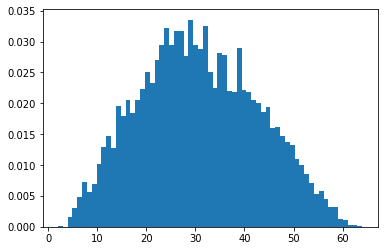

In [48]:
plt.hist(tages, density=True,bins=63) 
plt.show()

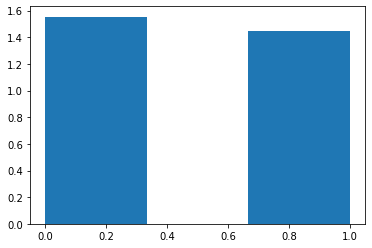

In [49]:
plt.hist(tgenders, density=True,bins=3) 
plt.show()

In [10]:
orders=[] 
orders_items=[] 

# сгенерируем 10000 заказов
for i in range(1,10001):
    if i<=len(users):
        user = users[i-1]
    else:
        user = users[np.random.randint(len(users))]
    user_id = user[0]
    gender = user[1]
    dishes = set()
        
    p = 0 #уменьшаем вероятность заказать основное блюдо на последующих итерациях
    for j in range(3):
        main_types = ['Breakfast', 'Beef', 'Chicken & Fish'] # категории главных блюд
        is_main_picked = [main_types, None]
        main_choice = np.random.choice(is_main_picked, p=[0.8-p, 0.2+p]) # будет ли в заказе главное блюдо?

        if main_choice:
            main_type = np.random.choice(main_types, p=[0.2, 0.60, 0.2]) # если да, то какое? 

            if main_type == 'Breakfast':
                # вручную заданные вероятности заказа блюд по полу, далее так же
                m = [0.08,0.07,0.07,0.15,0.1,0.05,0.05,0.02,0.02,0.02,0.05,0.05,0.07,0.04,0.05,0.06,0.05]
                f = [0.05,0.05,0.05,0.05,0.05,0.08,0.22,0.1,0.08,0.05,0.04,0.03,0.02,0.04,0.04,0.03,0.02]
                
                if gender == 1:
                    dishes.add(np.random.choice(menu['Breakfast'], p = m))
                elif gender == 0:
                    dishes.add(np.random.choice(menu['Breakfast'], p = f))
                
            elif main_type == 'Beef':
                m = [0.25,0.05,0.1,0.15,0.05,0.13,0.12,0.15]
                f = [0.05,0.2,0.15,0.1,0.2,0.1,0.1,0.1]

                if gender == 1:
                    dishes.add(np.random.choice(menu['Beef'], p = m))
                elif gender == 0:
                    dishes.add(np.random.choice(menu['Beef'], p = f))

            elif main_type == 'Chicken & Fish':
                prob=[0.2,0.1,0.04,0.04,0.1,0.2,0.2,0.04,0.04,0.04]
                dishes.add(np.random.choice(menu['Chicken']+menu['Fish'],p=prob))
        

        side_types = ['Salad','Snack']
        is_side_picked = [side_types, None]
        side_choice = np.random.choice(is_side_picked, p=[0.6-p, 0.4+p]) # будет ли в заказе салат/картошка?

        if side_choice:
            # также для мужчин и женщин разные вероятности заказа того или иного блюда
            if gender == 1:
                side_type = np.random.choice(side_types, p=[0.15, 0.85]) 

            elif gender == 0:
                side_type = np.random.choice(side_types, p=[0.35, 0.65])  

            if side_type == 'Salad':
                prob = [0.25,0.25,0,0.25,0.25]
                dishes.add(np.random.choice(menu['Salad'],p=prob))

            elif side_type == 'Snack':
                prob=[0.025,0.025,0.025,0.9,0.025]
                dishes.add(np.random.choice(menu['Snack'], p = prob))


        dessert_types = ['Dessert']
        is_dessert_picked = [dessert_types, None]
        dessert_choice = np.random.choice(is_dessert_picked, p=[0.6-p, 0.4+p]) # будет ли в заказе десерт?
        if dessert_choice:
            m = [0.03,0.05,0.1,0.1,0.02,0.1,0.1,0.01,0.05,0.05,0.01,0.01,0.01,0.05,0.01,0.05,0.05,0.1,0.1]
            f = [0.03,0.01,0.05,0.02,0.08,0.07,0.07,0.07,0.04,0.04,0.03,0.03,0.03,0.04,0.07,0.1,0.1,0.06,0.06]
            if gender == 1:
                dishes.add(np.random.choice(menu['Dessert'], p = m))
            elif gender == 0:
                dishes.add(np.random.choice(menu['Dessert'], p = f))


        drink_types = ['Hot Beverage', 'Cold Beverage']
        is_drink_picked = [drink_types, None]
        drink_choice = np.random.choice(is_drink_picked, p=[0.9-p, 0.1+p])  # будет ли в заказе напиток?

        if drink_choice:

            drink_type = np.random.choice(drink_types, p=[0.5, 0.5])  

            if drink_type == 'Hot Beverage':
                 dishes.add(np.random.choice(menu['Hot Beverage']))

            elif drink_type == 'Cold Beverage':
                 dishes.add(np.random.choice(menu['Cold Beverage']))

        
    order = {'order_id':i,'user_id':user_id} # создаем заказ 
    orders.append(order)
    
    for d in dishes:
        order_item = {'order_id':i, 'item_id':food_items.index(d)} # сопоставляем заказ и продукты
        orders_items.append(order_item)
            

In [11]:
orders = pd.DataFrame(orders).fillna(0)

In [12]:
orders_items = pd.DataFrame(orders_items).fillna(0)

In [13]:
orders.head()

,order_id,user_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


In [14]:
orders_items.head()

,item_id,order_id
0,66,1
1,90,1
2,40,1
3,1,1
4,86,1


In [15]:
# заполняем таблицу пользователей сгенерированными данными
for user in tqdm(users,total=len(users)):
    data = (bool(user[1]),int(user[2]),list(user[3]))
    cursor.execute("INSERT INTO users(gender, age_group_id, vector) VALUES(%s,%s,cube(%s))",data)
connect.commit()

100%|██████████| 5728/5728 [01:59<00:00, 50.71it/s]


In [16]:
# заполняем таблицу заказов сгенерированными данными

for _, order in tqdm(orders.iterrows(),total=len(orders)):  
    data = (int(order.user_id),)
    cursor.execute("INSERT INTO orders(user_id) VALUES(%s)", data)
connect.commit()

100%|██████████| 10000/10000 [03:11<00:00, 53.79it/s]


In [17]:
for _,order in tqdm(orders_items.iterrows(),total=len(orders_items)):
    data = (int(order.order_id), int(order.item_id+1))
    cursor.execute("INSERT INTO orders_items(order_id, item_id) values (%s, %s)", data)
    
connect.commit() 

100%|██████████| 79440/79440 [26:03<00:00, 48.49it/s]  


In [18]:
connect.close()